# 라벨링

### `3.1 동기`
- 금융 데이터를 레이블 하는 방법

### `3.2 고정-시간 호라이즌 기법`
- 좋은 통계적 성질을 갖지 못한다.
- 관측된 변동성과 상관없이 동일한 임계값을 가짐

대안
- 수익률의 롤링 지수 가중값 표준편차를 사용해 계산된, 변동하는 임계값에 대해 레이블하는 것
- 거래량이나 달러바를 이용

하지만, 경로가 가격을 앞선다는 것
- 손절 제한, 거래소에서 손절됐을 포지션으로부터 수익을 낼 수 있는 전략을 구축한다는 것은 현실성이 없음



### `3.3 동적 임계값 계산`
- 베팅에 관련된 리스크의 함수에 의해 이익 실현과 손절 시점을 설정

코드
- 지수 가중값 이동 표준편차에 span0일 기간만큼 적용해 일 중 계산지점에서의 일 변동성을 계산

### `3.4 트리플-배리어 기법`
- 최초로 도달한 배리어에 따라 관측값을 레이블함
- 2개의 horizontal 배리어와 1개의 vertical 배리어 설정 
  - horizontal: 이익 실현과 손실 제한 한계에 의해 정의, 상단 배리어가 먼저 도달하면 1, 하단 배리어가 먼저 도달하면 -1
  - vertical: 포지션을 취한 후 지나간 바의 개수에 의해 정의(만기 한도), 배리어에 도달할 경우 수익률의 부호로 하거나 0으로 정함 

### `3.5 방향과 크기 파악`
- 머신러닝 알고리즘이 베팅의 방향과 크기를 학습
- (?) pg.94 방향을 알아낸다는 것은 horizontal 배리어가 업거나 대칭이라는 것을 암시

### `3.6 메타-레이블`
- 적절한 베팅 크기

### `3.7 메타-레이블 이용하는 방법`
- 재현율 극대화
- {-1, 0, 1} -> {0, 1}

## EX

### `ex 3.1`

##### (a) Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where thethreshold is the standard deviation of daily returns (Snippet 3.1).

In [19]:
import numpy as np
import pandas as pd
import sys

sys.path.append('/content/drive/MyDrive/퀀트/library')

In [20]:
import matplotlib.pyplot as plt
from sampling import dollar_bars
from filters import cusum
from multiprocess_r import mpPandasObj

In [21]:
db = pd.read_csv('/content/drive/MyDrive/퀀트/data/dollar_day.csv', index_col='date', parse_dates=True)
db.columns = ['Close', 'Bid', 'Ask', 'Volume', 'Dollar Volume']
db = db[['Close', 'Volume', 'Dollar Volume']]

In [22]:
db = db.dropna()
db.head()

,Close,Volume,Dollar Volume
date,,,
2009-09-28,51.5300,100.0,5.153000e+03
2009-09-29,51.4900,700.0,3.604300e+04
2009-09-30,51.1900,1800.0,9.214200e+04
2009-10-01,50.3166,109373.0,5.503277e+06
2009-10-02,49.5100,600.0,2.970600e+04


In [23]:
def getDailyVol(close, span0=100):
  # 일별 거래량, 종가에 따라 재 인덱싱
  df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
  df0=df0[df0>0]
  df0=pd.Series(close.index[df0-1], index=close.index[close.shape[0]-df0.shape[0]:])
  df0=close.loc[df0.index]/close.loc[df0.values].values-1 # 일별 수익률
  df0=df0.ewm(span=span0).std()
  return df0

In [24]:
daily_vol = getDailyVol(db.Close, span0=100)
daily_vol.mean()

0.012960758569578196

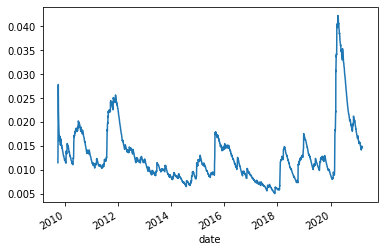

In [25]:
daily_vol.plot()

In [26]:
def cumsum_events(df: pd.Series, limit: float):
    idx, _up, _dn = [], 0, 0
    diff = df.diff()
    for i in range(1, len(diff)):
        _up, _dn = max(0, _up + diff.iloc[i]), min(0, _dn + diff.iloc[i])
        if _up > limit:
            _up = 0; idx.append(diff.index[i])
        elif _dn < - limit:
            _dn = 0; idx.append(diff.index[i])
        
    return pd.DatetimeIndex(idx)

In [27]:
tEvents = cumsum_events(db.Close, limit = daily_vol.mean())
tEvents

DatetimeIndex(['2009-09-29', '2009-09-30', '2009-10-01', '2009-10-02',
               '2009-10-05', '2009-10-06', '2009-10-07', '2009-10-08',
               '2009-10-09', '2009-10-12',
               ...
               '2021-02-25', '2021-02-26', '2021-03-01', '2021-03-02',
               '2021-03-03', '2021-03-04', '2021-03-05', '2021-03-08',
               '2021-03-09', '2021-03-10'],
              dtype='datetime64[ns]', length=2823, freq=None)

##### (b) Use Snippet 3.4 on a pandas series t1, where numDays = 1.

In [28]:
# 버티컬 배리어 추가 
t1=db.Close.index.searchsorted(tEvents+pd.Timedelta(days=1)) 
t1=t1[t1<db.Close.shape[0]] 
t1=pd.Series(db.Close.index[t1],index=tEvents[:t1.shape[0]]) # NaNs at end
t1

2009-09-29   2009-09-30
2009-09-30   2009-10-01
2009-10-01   2009-10-02
2009-10-02   2009-10-05
2009-10-05   2009-10-06
                ...    
2021-03-03   2021-03-04
2021-03-04   2021-03-05
2021-03-05   2021-03-08
2021-03-08   2021-03-09
2021-03-09   2021-03-10
Name: date, Length: 2822, dtype: datetime64[ns]

##### (c) On those sampled features, apply the triple-barrier method, where ptSl = [1,1] and t1 is the series you created in point 1.b.

In [29]:
# 최초 시간 도달 측정
'''
ptSl: 두 배리어의 너비, 0: 각 배리어 불능화
t1: vertical barrier의 타임스탬프를 가진 series, 무시하려면 False
trgt: 목표의 수익률의 절댓값
minRet: 트리플-배리어를 검색하기 위한 최소 목표 수익률
numThreads: 함수에서 현재 동시에 사용되고 있는 스레드 수
'''
def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads=1, t1=False, side=None):
    # 1) get target
    trgt = trgt.loc[trgt.index.intersection(tEvents)]
    trgt = trgt[trgt > minRet]
    # 2) get t1 (max holding period)
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents)
    # 3) form events object, apply stop loss on t1
    if side is None:
        side_, ptSl_ = pd.Series(1.0, index=trgt.index), [ptSl[0], ptSl[0]]
    else:
        side_, ptSl_ = side.loc[trgt.index], ptSl[:2]
    events = pd.concat({'t1': t1, 'trgt': trgt, 'side': side_}, axis=1).dropna(subset=['trgt'])
    df0 = mpPandasObj(func=applyPtSlOnT1, pdObj=('molecule', events.index), numThreads=numThreads, close=close, events=events, ptSl=ptSl_)
    events['t1'] = df0.dropna(how='all').min(axis=1) # pd.min ignores NaN
    if side is None:
        events = events.drop('side', axis=1)

    # store for later
    events['pt'] = ptSl[0]
    events['sl'] = ptSl[1]

    return events

In [30]:
def applyPtSlOnT1(close, events, ptSl, molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)

    if ptSl[0] > 0:
        pt = ptSl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events.index) # NaNs

    if ptSl[1] > 0:
        sl = - ptSl[1] * events_['trgt']
    else:
        sl = pd.Series(index=events.index) # 'mo NaNs

    for loc, t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0 = close[loc:t1] # path prices
        df0 = (df0 / close[loc] - 1) * events_.at[loc, 'side'] # path returns
        out.loc[loc, 'sl'] = df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc, 'pt'] = df0[df0>pt[loc]].index.min() # earliest profit take
    return out

In [31]:
events = getEvents(db.Close, tEvents=tEvents, ptSl=[1,1], t1=t1, numThreads=1, trgt=daily_vol, minRet=0.01)

In [32]:
events.head() 

,t1,trgt,pt,sl
2009-10-01,2009-10-02,0.011449,1,1
2009-10-02,2009-10-05,0.013210,1,1
2009-10-05,2009-10-06,0.023222,1,1
2009-10-06,2009-10-07,0.027800,1,1
2009-10-07,2009-10-08,0.025696,1,1


##### (d) Apply getBins to generate the labels.

In [33]:
# 방향과 크기를 레이블 
'''
ret: 최초로 배리어에 도달했을 때 실현된 수익률
bin: 결과의 부호에 따른 함수로 된 레이블 {-1, 0, 1}
'''
def getBins(events,close):
  #1) prices aligned with events
  events_=events.dropna(subset=['t1']) 
  px=events_.index.union(events_['t1'].values).drop_duplicates() 
  px=close.reindex(px,method='bfill')
  #2) create out object
  out=pd.DataFrame(index=events_.index) 
  out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1 
  out['bin']=np.sign(out['ret'])
  return out

In [34]:
bins = getBins(events, db.Close)

In [35]:
bins.head()

,ret,bin
2009-10-01,-0.016030,-1.0
2009-10-02,0.019871,1.0
2009-10-05,0.012005,1.0
2009-10-06,0.003074,1.0
2009-10-07,0.006300,1.0


In [36]:
bins['bin'].value_counts()

 1.0    1016
-1.0     852
 0.0      10
Name: bin, dtype: int64

### `ex 3.2` 

From exercise 1, use Snippet 3.8 to drop rare labels.

In [37]:
def dropLabels(events, mitPct=0.05):
    # apply weights, drop labels with insufficient examples
    while True:
        df0 = events['bin'].value_counts(normalize=True)
        if df0.min() > mitPct or df0.shape[0] < 3:
            break
        print("Dropped label", df0.argmin(), df0.min())
        events = events[events['bin'] != df0.index[df0.argmin()]]
    return events

In [38]:
dropLabels(bins).head()

Dropped label 2 0.005324813631522897


,ret,bin
2009-10-01,-0.016030,-1.0
2009-10-02,0.019871,1.0
2009-10-05,0.012005,1.0
2009-10-06,0.003074,1.0
2009-10-07,0.006300,1.0


### `ex 3.3`

Adjust the getBins function (Snippet 3.5) to return a 0 whenever the vertical barrier is the first one touched.

In [39]:
def barrier_touched(out_df, events):
    # We'll graciously use the barrier_touched method from
    # https://github.com/hudson-and-thames/mlfinlab/blob/master/mlfinlab/labeling/labeling.py#L164
    store = []
    for date_time, values in out_df.iterrows():
        ret = values['ret']
        target = values['trgt']

        pt_level_reached = ret > target * events.loc[date_time, 'pt']
        sl_level_reached = ret < -target * events.loc[date_time, 'sl']

        if ret > 0.0 and pt_level_reached:
            # Top barrier reached
            store.append(1)
        elif ret < 0.0 and sl_level_reached:
            # Bottom barrier reached
            store.append(-1)
        else:
            # Vertical barrier reached
            store.append(0)

    # Save to 'bin' column and return
    out_df['bin'] = store
    return out_df


def getBins(events, close):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    Case 1: ('side' not in events): bin in (-1, 1) <- label by price action
    Case 2: ('side' in events): bin in (0, 1) <- label by pnl (meta-labeling)
    '''
    # 1) prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')
    # 2) create out object
    out = pd.DataFrame(index=events_.index)

    out['ret'] = px.loc[events_['t1'].values].values / px.loc[events_.index] - 1
    if 'side' in events_:
        out['ret'] *= events_['side']  # meta-labeling

    out['trgt'] = events_['trgt']
    out = barrier_touched(out, events)

    if 'side' in events_:
        out.loc[out['ret'] <= 0, 'bin'] = 0
        
    if 'side' in events_:
        out['side'] = events['side']
    return out

In [40]:
bins = getBins(events, db.Close)

In [41]:
bins['bin'].value_counts()

 0    1589
-1     145
 1     144
Name: bin, dtype: int64

### `ex 3.4`

Develop a trend-following strategy based on a popular technical analysis statistic (e.g. MA Crossover). For each observation, the model suggests a side, but not a size of the bet.

##### (a) Derive meta-labels for ptSl = [1,2] and t1 where numDays=1. Use as trgt the daily standard deviation as computed by Snippet 3.1.

In [42]:
def getVerticalBarriers(close, tEvents, numDays):
    t1 = close.index.searchsorted(tEvents+pd.Timedelta(days=numDays))
    t1 = t1[t1 < close.shape[0]]
    t1 = pd.Series(close.index[t1], index=tEvents[:t1.shape[0]]) # NaNs at the end
    return t1

In [43]:
df = db.copy().truncate(before='2017')
tEvents = cusum(df['Close'], getDailyVol(df['Close']).mean())
t1 = getVerticalBarriers(df['Close'], tEvents, numDays=1)
events = getEvents(df.Close, tEvents=tEvents, ptSl=[1,2], t1=t1, trgt=daily_vol, minRet=0.01)

In [44]:
slow_ma = df.Close.rolling(100).mean()
fast_ma = df.Close.rolling(10).mean()

long_signals = (fast_ma >= slow_ma)
short_signals = (fast_ma < slow_ma)
close = df['Close']

events.loc[long_signals, 'side'] = 1
events.loc[short_signals, 'side'] = -1
events['side'] = events['side'].shift()

In [45]:
events.head()

,t1,trgt,pt,sl,side
2018-02-07,2018-02-08,0.010212,1,2,NaN
2018-02-08,2018-02-09,0.011324,1,2,1.0
2018-02-20,2018-02-21,0.011981,1,2,1.0
2018-02-21,2018-02-22,0.012094,1,2,-1.0
2018-02-27,2018-02-28,0.011972,1,2,-1.0


In [46]:
bins['bin'].value_counts()

 0    1589
-1     145
 1     144
Name: bin, dtype: int64

(b) Train a random forest to decide whether to trade or not. Note: The decision is whether to trade or not, {0,1}, since the underlying model (the crossing moving average) has decided the side, {-1, 1}.

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators=1000, random_state=42)

In [48]:
df['log_ret'] = np.log(df.Close).diff() 
# 변동성
df['vol5'] = df['log_ret'].rolling(5).std() 
df['vol10'] = df['log_ret'].rolling(10).std()
df['vol15'] = df['log_ret'].rolling(15).std()

# 계열 상관관계
df['serialcorr20-1'] = df['log_ret'].rolling(20).apply(lambda x: pd.Series(x).autocorr(lag=1))
df['serialcorr20-2'] = df['log_ret'].rolling(20).apply(lambda x: pd.Series(x).autocorr(lag=2))
df['serialcorr20-3'] = df['log_ret'].rolling(20).apply(lambda x: pd.Series(x).autocorr(lag=3))

df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1
df['side'] = df['side'].shift()

In [49]:
train_features = df.loc[events.index][['side', 'vol5', 'vol10', 'vol15', 'serialcorr20-1', 'serialcorr20-2', 'serialcorr20-3']]
train_labels = bins.loc[events.index]['bin']

In [50]:
rf.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [51]:
prediction = rf.predict(train_features)

In [65]:
decision_trade = train_labels * prediction

In [66]:
decision_trade.value_counts()

0    232
1     52
Name: bin, dtype: int64

### `ex 3.5`

Develop a mean-reverting strategy based on Bollinger Bands. For each observation, the model suggests a side, but not a size of the bet.


##### (a) Derive meta-labels for ptSl = [0,2] and t1 where numDays=1. Use as trgt the daily standard deviation.

In [54]:
events = getEvents(close, tEvents=tEvents, ptSl=[0,2], t1=t1, trgt=daily_vol, minRet=0.01)
events.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,t1,trgt,pt,sl
2018-02-07,2018-02-08,0.010212,0,2
2018-02-08,2018-02-09,0.011324,0,2
2018-02-20,2018-02-21,0.011981,0,2
2018-02-21,2018-02-22,0.012094,0,2
2018-02-27,2018-02-28,0.011972,0,2


##### (b) Train a random forest to decide whether to trade or not. Use as features: volatility, serial correlation, and the crossing moving averages from exercise 2.

In [55]:
def bbands(close, window, stdev=2):
    ma = close.rolling(window).mean()
    std = close.rolling(window).std()
    return (ma + stdev * std, ma - stdev * std)
    
df['bb_upper_band'], df['bb_lower_band'] = bbands(close, 100, 2)
short_signals = close > df['bb_upper_band']
long_signals = close < df['bb_lower_band']

df['side'] = np.nan
df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1
df['side'] = df['side'].ffill() # long until we're short
df = df.shift() # No look-ahead

In [56]:
df.side.value_counts()

 1.0    443
-1.0    431
Name: side, dtype: int64

In [57]:
train_features = df.loc[events.index][['side', 'vol5', 'vol10', 'vol15', 'serialcorr20-1', 'serialcorr20-2', 'serialcorr20-3']]
train_labels = bins.loc[events.index]['bin']

rf = RandomForestClassifier(n_estimators=100, random_state=10, max_depth=5)
rf.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

##### (c) What is the accuracy of predictions from the primary model (i.e. if the secondary model does not filter the bets)? What are the precision, recall, and F-1 scores?

In [58]:
prediction2 = rf.predict(train_features)

In [59]:
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

primary_forecast = pd.DataFrame(train_labels.values)
primary_forecast['pred'] = train_features['side'].values
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred)) # 실제는 1, 예측은 0 

              precision    recall  f1-score   support

          -1       0.10      0.33      0.16        30
           0       0.00      0.00      0.00       232
           1       0.07      0.59      0.12        22

    accuracy                           0.08       284
   macro avg       0.06      0.31      0.09       284
weighted avg       0.02      0.08      0.03       284

Confusion Matrix
[[ 10   0  20]
 [ 79   0 153]
 [  9   0  13]]

Accuracy
0.08098591549295775


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### (d) What is the accuracy of prediction from the secondary model? What are the precision, recall, and F1-scores?

In [60]:
y_train = train_labels.values
X_train = train_features

# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)

print(classification_report(y_true=actual, y_pred=pred))
print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

              precision    recall  f1-score   support

          -1       0.10      0.33      0.16        30
           0       0.00      0.00      0.00       232
           1       0.07      0.59      0.12        22

    accuracy                           0.08       284
   macro avg       0.06      0.31      0.09       284
weighted avg       0.02      0.08      0.03       284

Confusion Matrix
[[  6  24   0]
 [  0 232   0]
 [  0  15   7]]

Accuracy
0.8626760563380281


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
